
## Linear Regression: Coded by E. Porter and N. Wong



# Data Loading and Exploration

fraudTrain.csv
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
Index:
trans_date_trans_time:
cc_num:
merchant:
category:
amt:
first:
last:
gender:
street:
city:
state:
zip:
lat:
long:
city_pop:
job:
dob:
trans_num:
unix_time:
merch_lat:
merch_long:
is_fraud:


In [1]:
!nvidia-smi

Fri Dec  6 11:42:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:07:00.0  On |                  N/A |
|  0%   51C    P8             10W /  200W |    1693MiB /   8192MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, root_mean_squared_error
import seaborn as sns
from sklearn import linear_model
import warnings

Label_encoder = LabelEncoder()

In [3]:
fraudTrain_data = pd.read_csv('fraudTrain.csv',header = 0,sep=',')

fraudTrain_data.columns = ['Index','trans_date_trans_time','cc_num','merchant','category','amt','first','last','gender','street','city','state','zip','lat','long',
             'city_pop','job','dob','trans_num','unix_time','merch_lat','merch_long','is_fraud']
fraudTrain_data.head()

,Index,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
fraudTrain_data.describe()

,Index,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [5]:
fraudTrain_data.isnull().sum()

Index                    0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Exploratory Data Analysis (EDA)
Visualizing the important characteristics of the dataset

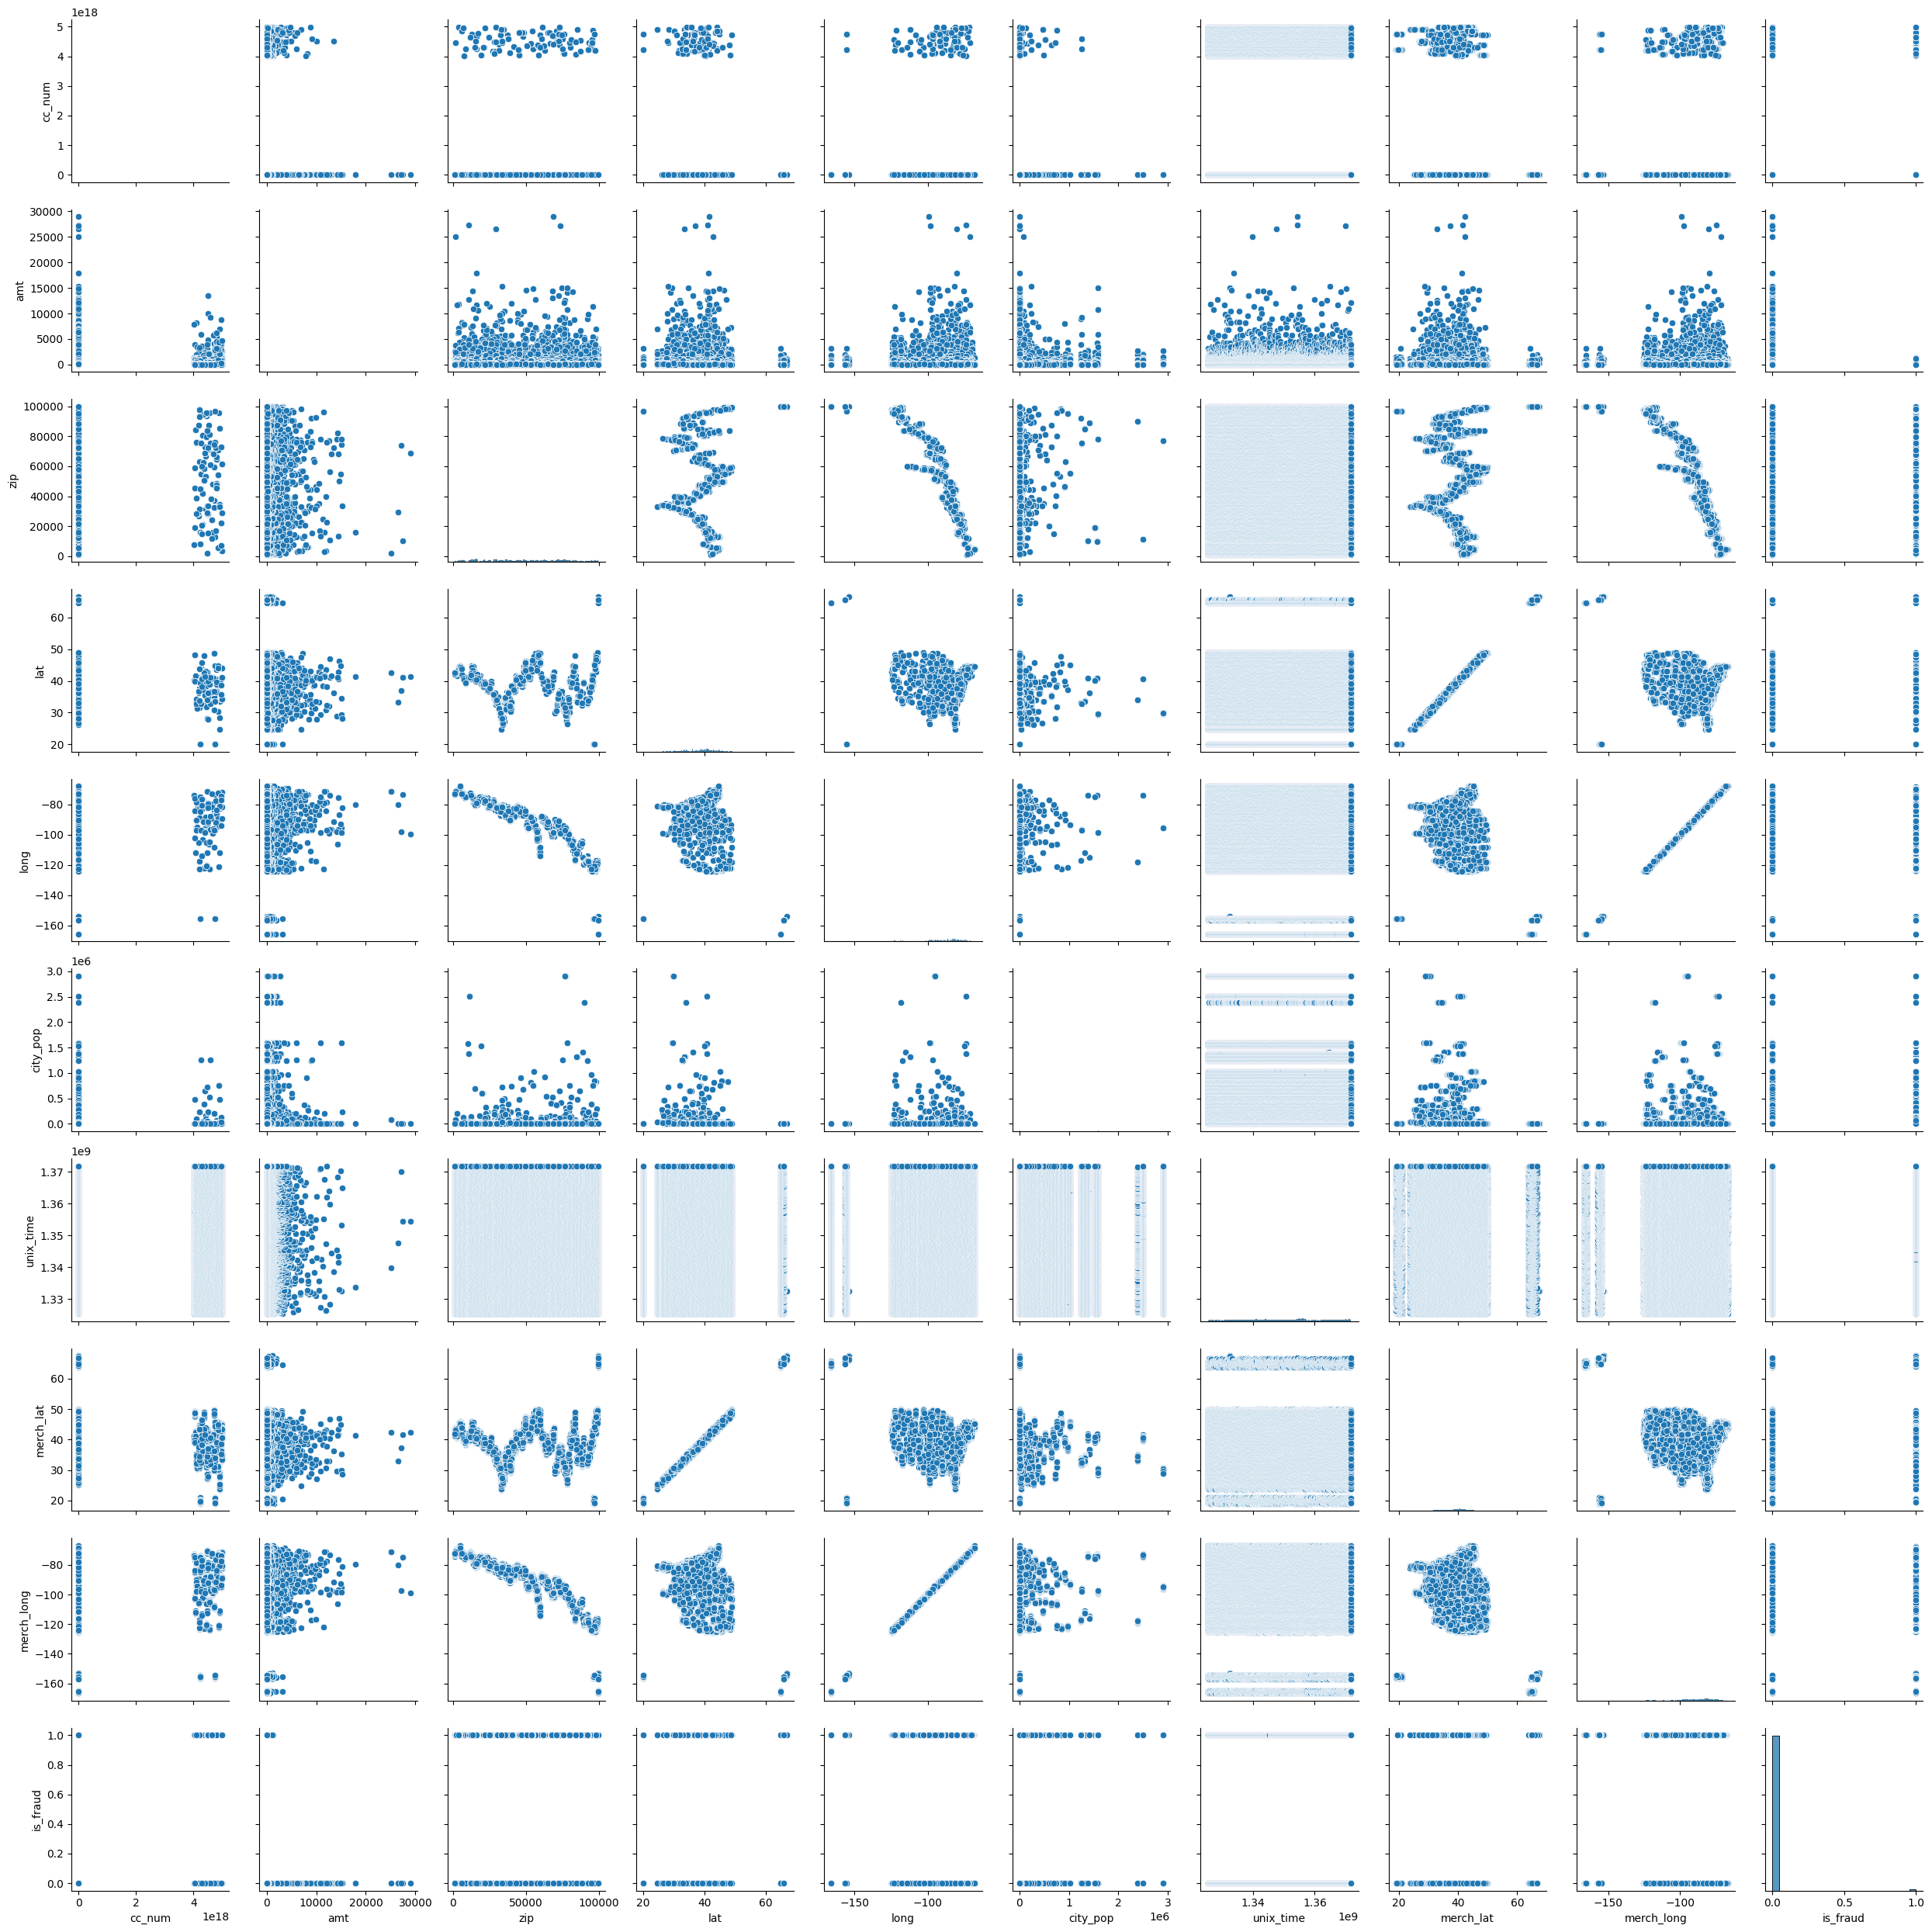

In [6]:
fraudTrain_data_cols = ['trans_date_trans_time','cc_num','amt','zip','lat','long','city_pop','dob','trans_num','unix_time','merch_lat','merch_long','is_fraud']

sns.pairplot(fraudTrain_data[fraudTrain_data_cols], height=2.5)

plt.tight_layout()
# plt.savefig('images/10_03.png', dpi=300)
plt.show()

**Convert data in data set**: 

C:\Users\Nick\AppData\Local\Temp\ipykernel_20876\3659571565.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fraudTrain_data['gender'] = fraudTrain_data['gender'].replace({'F': 0, 'M': 1})


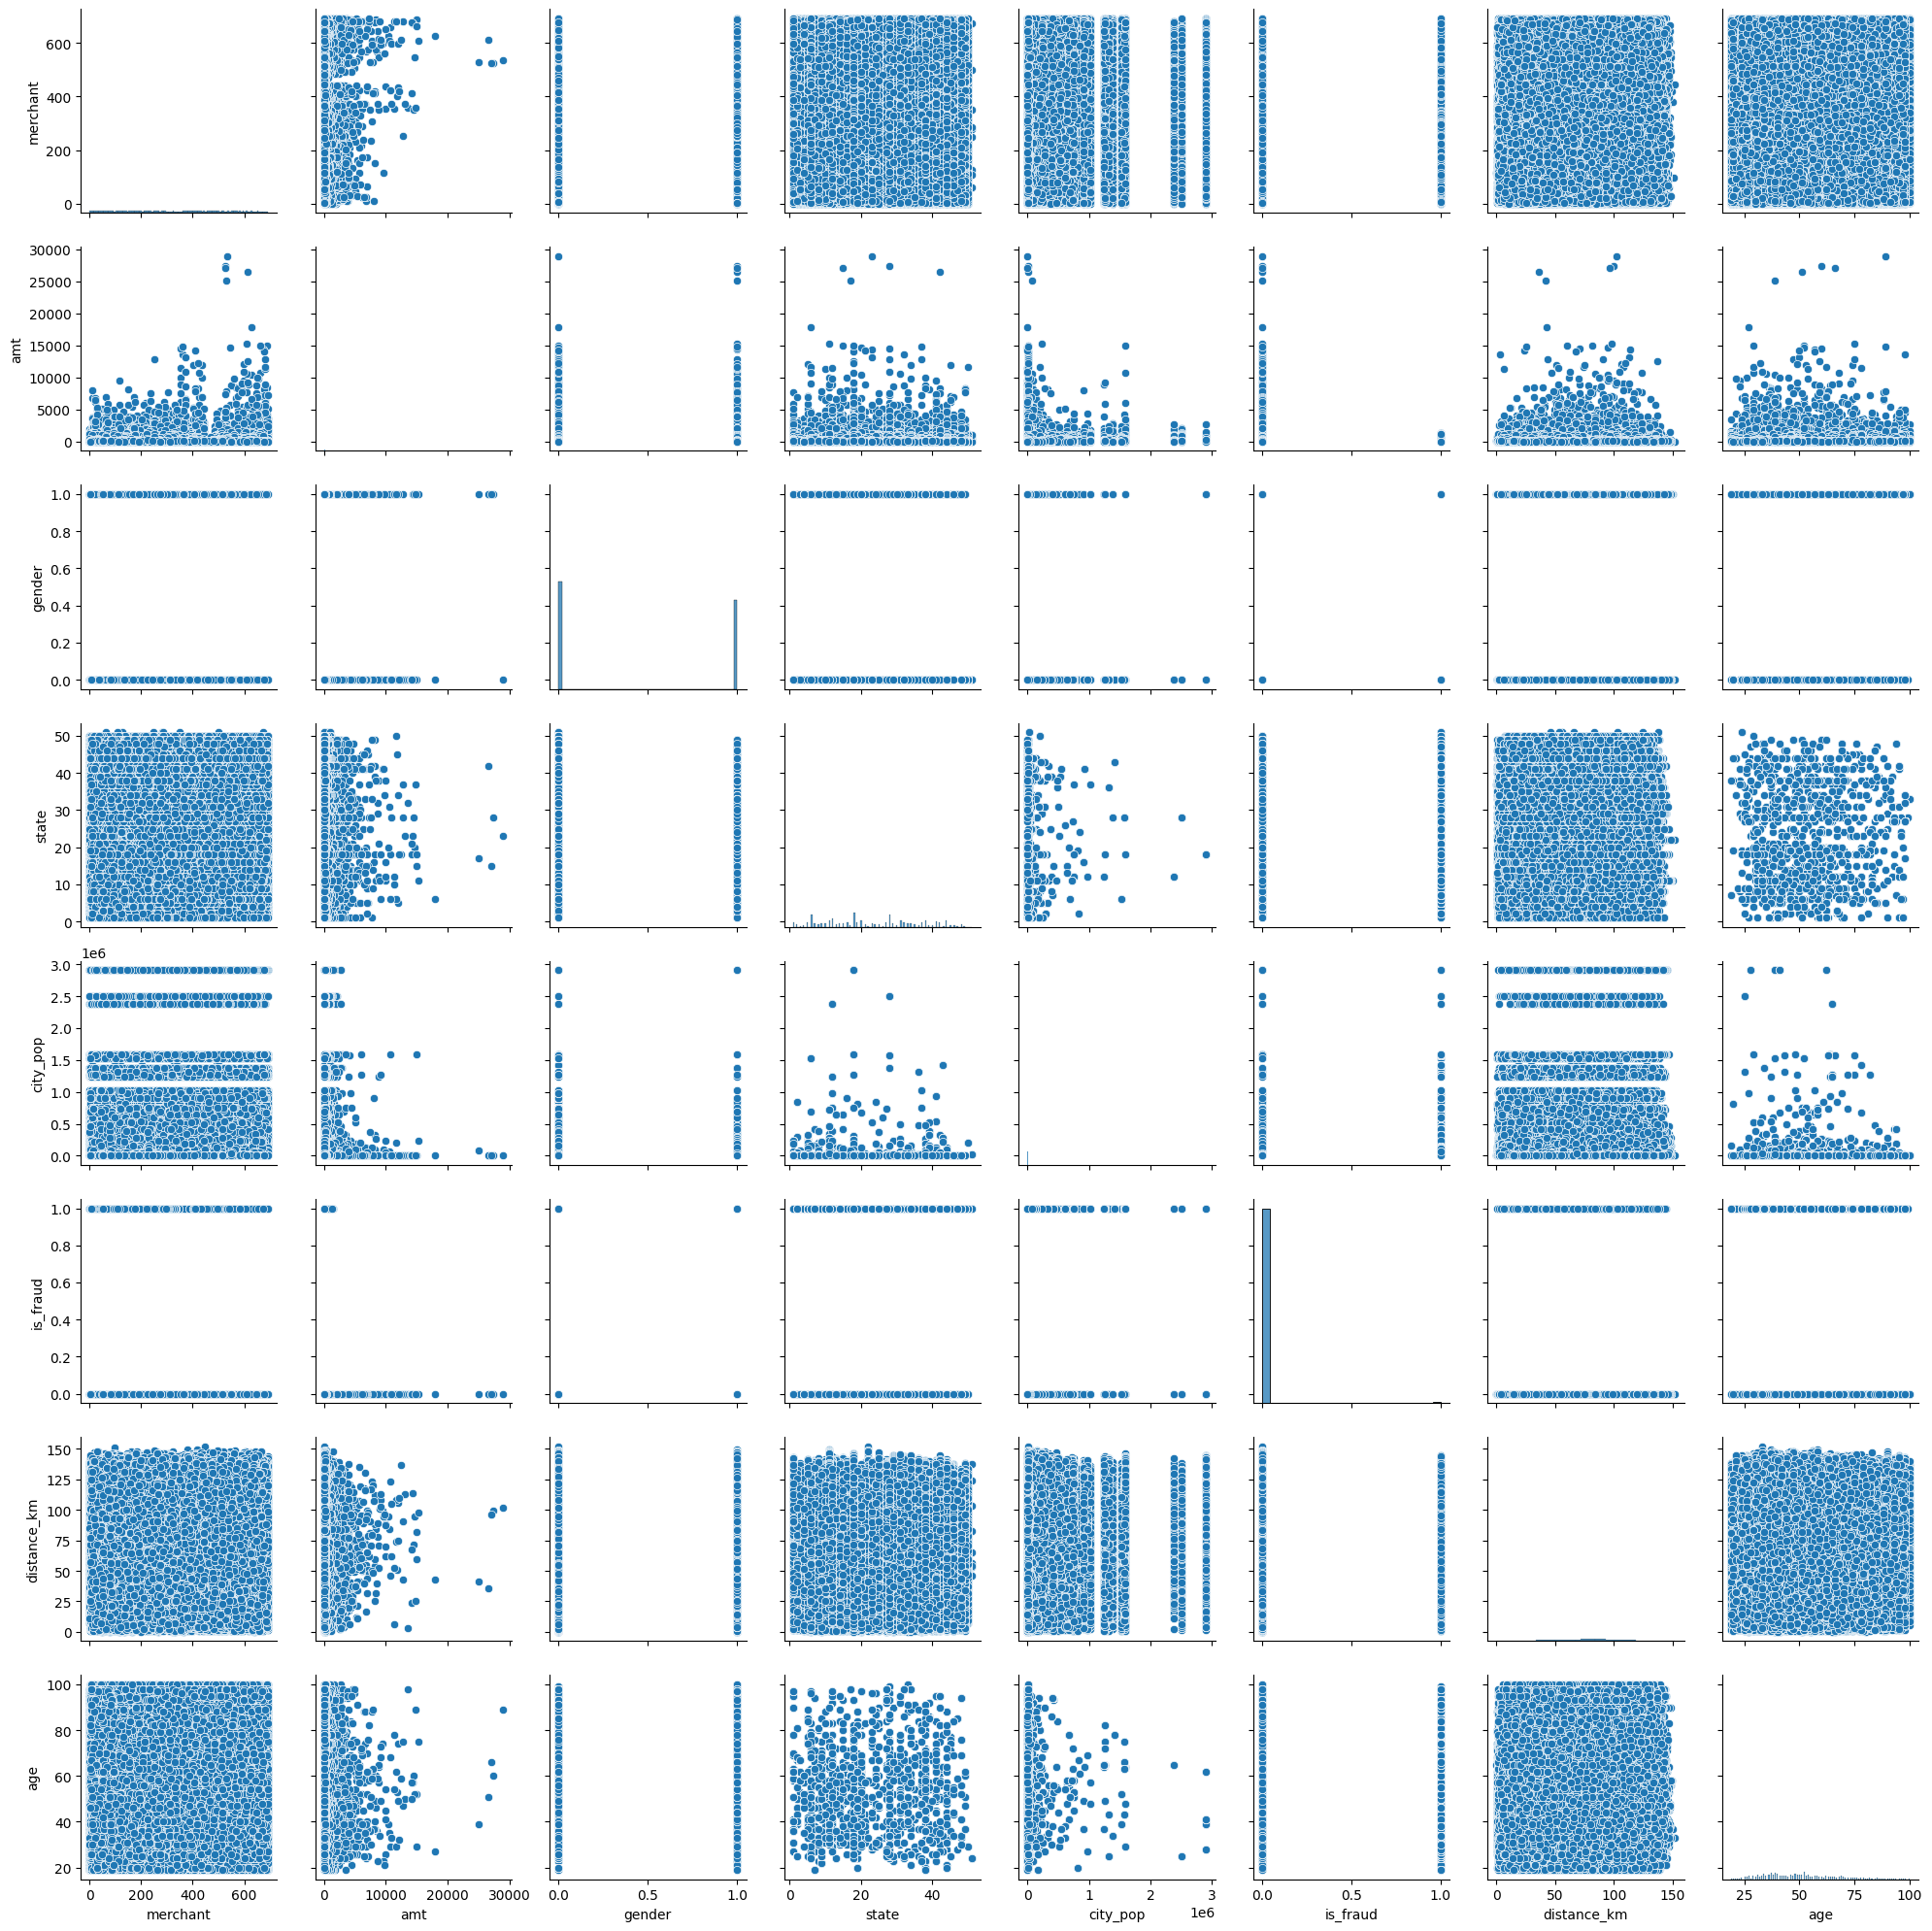

In [7]:
from datetime import datetime

fraudTrain_data['gender'] = fraudTrain_data['gender'].replace({'F': 0, 'M': 1})

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
fraudTrain_data['distance_km'] = haversine(fraudTrain_data['lat'], fraudTrain_data['long'], fraudTrain_data['merch_lat'], fraudTrain_data['merch_long'])

# Replace 'state' column with numeric values from 1 to 52
fraudTrain_data['state'], unique_states = pd.factorize(fraudTrain_data['state'])
fraudTrain_data['state'] += 1  # Make it 1-based index

# Replace 'merchant' column with numeric values from 1 to X for each unique merchant
fraudTrain_data['merchant'], unique_merchants = pd.factorize(fraudTrain_data['merchant'])
fraudTrain_data['merchant'] += 1  # Make it 1-based index

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
fraudTrain_data['age'] = fraudTrain_data['dob'].apply(calculate_age)

# Feature extraction:
fraudTrain_data_col2 = ['trans_date_trans_time','merchant','amt','gender','state','city_pop','is_fraud','distance_km','age']

sns.pairplot(fraudTrain_data[fraudTrain_data_col2], height=2.5)

plt.tight_layout()
# plt.savefig('images/10_03.png', dpi=300)
plt.show()

# Correlation and Feature Selection

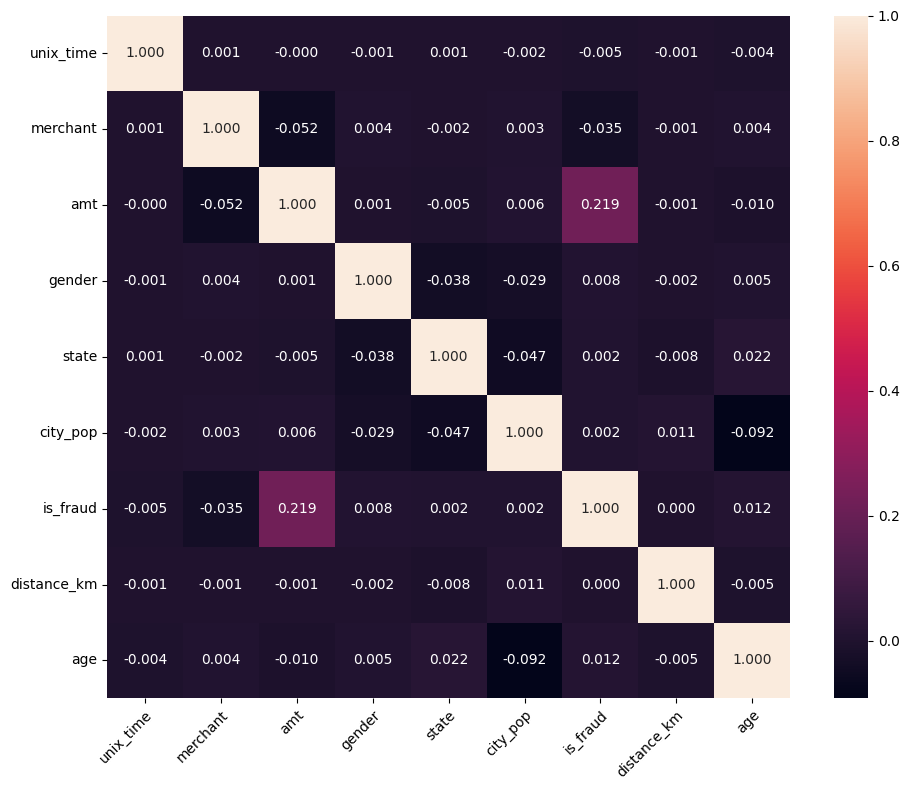

In [8]:
# Feature extraction
#fraudTrain_data_col2 = ['trans_date_trans_time', 'merchant', 'amt', 'gender', 'state', 'city_pop', 'is_fraud', 'distance_km', 'age']
fraudTrain_data_col2 = ['unix_time','merchant', 'amt', 'gender', 'state', 'city_pop', 'is_fraud', 'distance_km', 'age']

# Filter for numeric columns only
numeric_columns = fraudTrain_data[fraudTrain_data_col2].select_dtypes(include=[np.number])

cm = np.corrcoef(fraudTrain_data[fraudTrain_data_col2].values.T)

#  figure size 
plt.figure(figsize=(10, 8)) 
# Adjust the width and height as needed
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.3f',
                 annot_kws={'size': 10},
                 yticklabels=fraudTrain_data_col2,
                 xticklabels=fraudTrain_data_col2)


# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
# plt.savefig('images/10_04.png', dpi=1200)
plt.show()

# Model Testing and Fitting

In [25]:
# Load the dataset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['name'] = Label_encoder.fit_transform(data_train['name'])

data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category'] = Label_encoder.fit_transform(data_train['category'])

data_train['address'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

data_train = data_train.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])

In [26]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['name'] = Label_encoder.fit_transform(data_test['name'])

data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category'] = Label_encoder.fit_transform(data_test['category'])

data_test['address'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

data_test = data_test.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])

In [27]:
# Separate the independent variables (features) and the dependent variable (target) for training
# Dropping the 'is_fraud' column from the training dataset to use as features (X_train)
X_train = data_train.drop(columns=['is_fraud'], axis=1)

# Assigning the 'is_fraud' column as the target variable (y_train)
y_train = data_train['is_fraud']

# Initializing a linear regression model using the scikit-learn library
reg = linear_model.LinearRegression()

In [28]:
# Fitting the linear regression model to the training data
reg.fit(X_train, y_train)

LinearRegression()

In [29]:
# Preparing the test data by separating features and the target variable
# Dropping the 'is_fraud' column from the test dataset to use as features (X_test)
X_test = data_test.drop(columns=['is_fraud'], axis=1)

# Assigning the 'is_fraud' column as the target variable for the test set (y_test)
y_test = data_test['is_fraud']

In [30]:
# Calculating the R^2 value (coefficient of determination) for the model on the test data
# This measures how well the model's predictions match the actual target values in y_test
# The R^2 value ranges from 0 to 1, where a higher value indicates a better fit
r_squared = reg.score(X_test, y_test)

# Printing the R^2 value for evaluation
print("R^2 Value:", r_squared)

R^2 Value: 0.0002086082223614616
